In [1]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('05-augmentation-regularization-pytorch')
jovian.set_colab_id('1VijugOHXRYhur8jGndncwRXoxntdpd4l')

# Classifying CIFAR10 images using Resnets, Regularisation and Data Augmentation


In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch.nn.functional as F
import tarfile
import torch.nn as nn

from torchvision.datasets.utils import download_url
from torchvision.datasets import  ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tfs
from torch.utils.data import random_split
from torchvision.utils import make_grid

# Preparing the dataset

In [3]:
dataset_url = 'https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz'
download_url(dataset_url, '.')

Using downloaded and verified file: ./cifar10.tgz


In [4]:
with tarfile.open('cifar10.tgz','r') as tar:
  tar.extractall(path='./data')

In [5]:
data_dir = './data/cifar10/'
print(os.listdir(data_dir))

classes = os.listdir(data_dir + 'train')
print(classes)

['train', 'test']
['cat', 'dog', 'airplane', 'automobile', 'deer', 'horse', 'truck', 'bird', 'ship', 'frog']


## Load ImageFolder and Apply Data Augmentation, Normalisation and Transforms

In [6]:
# Data Transforms 
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tfs.Compose([tfs.RandomCrop(32, padding=4, padding_mode='reflect'),
                          tfs.RandomHorizontalFlip(),
                          # tfs.RandomRo
                          # tfs.RandomResizedCrop(256, scale=(0.5, 0.9), ratio=(1,1)),
                          tfs.ToTensor(),
                          tfs.Normalize(*stats, inplace=True)])

valid_tfms = tfs.Compose(([tfs.ToTensor(),tfs.Normalize(*stats)]))

In [7]:
# PyTorch Datasets
train_ds = ImageFolder(data_dir+'train', transform=train_tfms)
valid_ds = ImageFolder(data_dir+'test', transform=valid_tfms)

In [8]:
batch_size = 400

In [9]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_loader = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [10]:
def denormalize(images, means, std):
  means = torch.tensor(means).reshape(1, 3, 1, 1)
  stds = torch.tensor(std).reshape(1, 3, 1, 1)
  return images * stds + means

def show_batch(dl):
  for images, label in dl:
    fig, ax = plt.subplots(figsize=(12,12))
    ax.set_xticks([]); ax.set_yticks([])
    denorm = denormalize(images, *stats)
    ax.imshow(make_grid(denorm[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


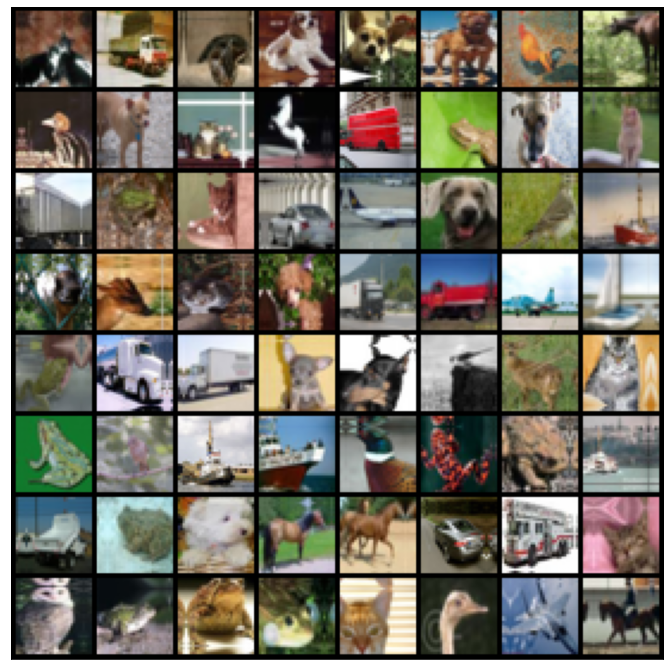

In [11]:
show_batch(train_loader)

# Using a GPU

In [12]:
def get_default_device():
  """Pick GPU if availabel, else CPU"""
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  if isinstance(data, (list,tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  """ Wrap a dataloader to move data into device"""
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    """ Yeild a batch of data after moving it to device"""
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    """ Number of batches"""
    return len(self.dl)

In [13]:
device = get_default_device()
device

device(type='cuda')

In [14]:
train_loader = DeviceDataLoader(train_loader, device)
valid_loader = DeviceDataLoader(valid_loader, device)

# Model with Residual Blocks and Batch Normalization

## Residual Block


In [15]:
class SimpleResidualBloack(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
    self.relu1 = nn.ReLU()
    self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
    self.relu2 = nn.ReLU()

  def forward(self, x):
    out = self.conv1(x)
    out = self.relu1(out)
    out = self.conv2(out)
    out = self.relu2(out)
    return out + x

In [16]:
simple_resnet = to_device(SimpleResidualBloack(), device)
simple_resnet

SimpleResidualBloack(
  (conv1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
)

In [17]:
for images, labels in train_loader:
  print(images.shape)
  out = simple_resnet(images)
  print(out.shape)
  break

del simple_resnet, images, labels
torch.cuda.empty_cache()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([400, 3, 32, 32])
torch.Size([400, 3, 32, 32])


# Define the Model

In [18]:
class ImageClassificationBaseline(nn.Module):
  
  def training_step(self,batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    return loss

  def validation_step(self,batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = self.accuracy(out, labels)
    return {'val_loss':loss, 'val_acc':acc}

  def accuracy(self, outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / preds.numel())

  def validation_step_end(self, val_outputs, train_outputs):
    val_batch_losses = [x['val_loss'] for x in val_outputs]
    val_epoch_loss = torch.stack(val_batch_losses).mean()
    val_batch_acc = [x['val_acc'] for x in val_outputs]
    val_epoch_acc = torch.stack(val_batch_acc).mean()

    train_batch_losses = [x['val_loss'] for x in train_outputs]
    train_epoch_loss = torch.stack(train_batch_losses).mean()
    train_batch_acc = [x['val_acc'] for x in train_outputs]
    train_epoch_acc = torch.stack(train_batch_acc).mean()

    return {'train_loss':train_epoch_loss.item(), 'train_acc':train_epoch_acc.item(), 'val_loss':val_epoch_loss.item(), 'val_acc':val_epoch_acc.item()}

  def epoch_end(self, epoch, num_epochs, results):
    print("Epoch [{}/{}]: train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, num_epochs, 
                                    results['train_loss'], results['train_acc'], results['val_loss'], results['val_acc']))

In [19]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor( torch.sum(preds == labels).item() / preds.numel())

In [20]:
def conv_block(in_channels, out_channels, pool=False):
  layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)]
  if pool: layers.append(nn.MaxPool2d(2))
  return nn.Sequential(*layers)

class ResNet9(ImageClassificationBaseline):
  def __init__(self, in_channels, num_classes):
    super().__init__()
    # 3 x 32 x 32
    self.conv1 = conv_block(in_channels, 64) # 64 x 32 x 32
    self.conv2 = conv_block(64, 128, pool=True) # 128 x 16 x 16
    self.res1 = nn.Sequential(conv_block(128, 128),
                              conv_block(128, 128)) # 128 x 16 x 16

    self.conv3 = conv_block(128, 256, pool=True) # 256 x 8 x 8
    self.conv4 = conv_block(256, 512, pool=True) # 512 x 4 x 4
    self.res2 = nn.Sequential(conv_block(512, 512),
                              conv_block(512, 512)) # 512 x 4 x 4
    
    self.classifier = nn.Sequential(nn.MaxPool2d(4),  # 512 x 1 x 1
                                    nn.Flatten(),     # 512
                                    nn.Dropout(0.2), 
                                    nn.Linear(512, num_classes))
    
  def forward(self, xb):

    out = self.conv1(xb)
    out = self.conv2(out)
    out = self.res1(out) + out

    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out) + out

    out = self.classifier(out)

    return out
  

In [21]:
model = to_device(ResNet9(3, 10), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

# Training the Model

In [22]:
@torch.no_grad() # No need to calculate any gradients
def evaluate(model, val_loader, train_loader):
  model.eval() # Tells the model that it is evaluation step, so no backpropagation, dropout, and batch normalization during evaluation
  val_outputs = [model.validation_step(batch) for batch in val_loader]
  train_outputs = [model.validation_step(batch) for batch in train_loader]
  return model.validation_step_end(val_outputs, train_outputs)


def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, weight_decay=0, grad_clip=None, opt_func = torch.optim.SGD):

  torch.cuda.empty_cache()
  history = []

  # setup custom optimizer with weight decay
  optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
  # setup one-cycle learning rate scheduler
  sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

  for epoch in range(epochs):
    # Training phase
    model.train() # Model is trained 
    lrs = []

    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()

      # Grad-Clipping
      if grad_clip:
        nn.utils.clip_grad_value_(model.parameters(), grad_clip)

      optimizer.step()
      optimizer.zero_grad()

      # Record and update learning rate
      lrs.append(get_lr(optimizer))
      sched.step()

    # Validation phase
    results = evaluate(model, valid_dl, train_dl)
    results['lrs'] = lrs
    model.epoch_end(epoch, epochs, results)
    history.append(results)

  return history



In [23]:
history = [evaluate(model, valid_loader, train_loader)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'train_acc': 0.10000000149011612,
  'train_loss': 2.3067827224731445,
  'val_acc': 0.13461539149284363,
  'val_loss': 2.298126220703125}]

In [24]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [25]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_loader,
                         valid_loader, weight_decay=weight_decay,
                         grad_clip=grad_clip, opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0/8]: train_loss: 1.5978, train_acc: 0.5135, val_loss: 1.5997, val_acc: 0.5112
Epoch [1/8]: train_loss: 1.2070, train_acc: 0.6118, val_loss: 1.1174, val_acc: 0.6415
Epoch [2/8]: train_loss: 0.7692, train_acc: 0.7369, val_loss: 0.7635, val_acc: 0.7474
Epoch [3/8]: train_loss: 0.6791, train_acc: 0.7722, val_loss: 0.6786, val_acc: 0.7754
Epoch [4/8]: train_loss: 0.5835, train_acc: 0.8022, val_loss: 0.6036, val_acc: 0.7929
Epoch [5/8]: train_loss: 0.3493, train_acc: 0.8776, val_loss: 0.3921, val_acc: 0.8671
Epoch [6/8]: train_loss: 0.2476, train_acc: 0.9142, val_loss: 0.3328, val_acc: 0.8899
Epoch [7/8]: train_loss: 0.1962, train_acc: 0.9332, val_loss: 0.2899, val_acc: 0.9036
CPU times: user 1min 1s, sys: 46.1 s, total: 1min 47s
Wall time: 7min 30s


In [39]:
train_time1 = '7:30'

In [27]:
import pandas as pd

In [28]:
history = pd.DataFrame(history)

acc = pd.DataFrame({'train_acc':history['train_acc'],'val_acc':history['val_acc']})
loss = pd.DataFrame({'train_loss':history['train_loss'],'val_loss':history['val_loss']})
lrs = pd.DataFrame({'lrs':history['lrs']})

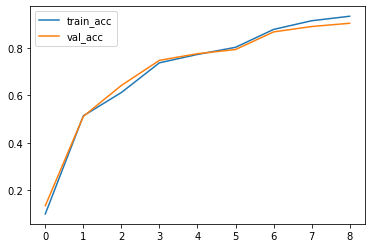

In [29]:
acc.plot()

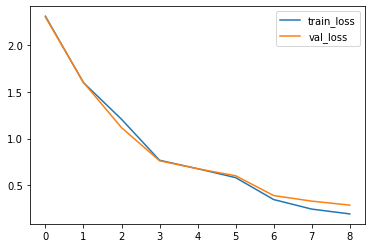

In [30]:
loss.plot()

# Predict on individual Images

In [31]:
def predict_image(img, model):
  xb = to_device(img.unsqueeze(0), device)
  yb = model(xb)
  _, preds = torch.max(yb, dim=1)
  return train_ds.classes[preds[0].item()]

Label:  airplane , Predicted:  airplane


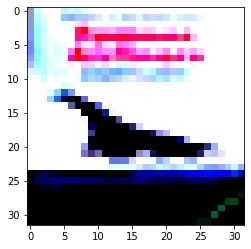

In [32]:
img, label = valid_ds[0]
plt.imshow(img.permute(1,2,0).clamp(0,1))
print('Label: ',train_ds.classes[label],', Predicted: ', predict_image(img,model))

Label:  automobile , Predicted:  automobile


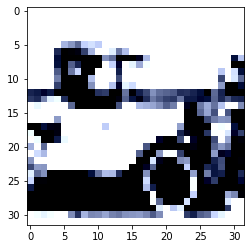

In [33]:
img, label = valid_ds[1002]
plt.imshow(img.permute(1,2,0).clamp(0,1))
print('Label: ',train_ds.classes[label],', Predicted: ', predict_image(img,model))

Label:  frog , Predicted:  frog


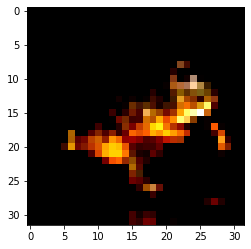

In [34]:
img, label = valid_ds[6153]
plt.imshow(img.permute(1,2,0).clamp(0,1))
print('Label: ',train_ds.classes[label],', Predicted: ', predict_image(img,model))

# Save and Commit 

In [41]:
h_d = history.to_dict()

In [35]:
torch.save(model.state_dict(), 'cifar10-resnet9.pth')

In [54]:
jovian.reset()
jovian.log_hyperparams(arch='resnet9',
                           epochs=epochs,
                           lr=max_lr,
                           scheduler='one-cycle',
                           weight_decay=weight_decay,
                           grad_clip=grad_clip,
                           opt=opt_func.__name__)

[jovian] Hyperparams logged.


In [56]:
jovian.log_metrics(val_loss=history.iloc[len(history)-1]['val_loss'],
                   val_acc=history.iloc[len(history)-1]['val_acc'],
                   train_loss=history.iloc[len(history)-1]['train_loss'],
                   train_acc=history.iloc[len(history)-1]['train_acc'])

[jovian] Metrics logged.


In [57]:
jovian.commit(project='05-cifar10-resnet',
              outputs=['cifar10-resnet9.pth'],
              environment=None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/developer-jnk/05-cifar10-resnet


'https://jovian.ai/developer-jnk/05-cifar10-resnet'

In [36]:
!pip install jovian --upgrade --quiet

In [37]:
import jovian

In [38]:
# Execute this to save new versions of the notebook
jovian.commit(project="05-augmentation-regularization-pytorch")

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/developer-jnk/05-augmentation-regularization-pytorch


'https://jovian.ai/developer-jnk/05-augmentation-regularization-pytorch'